## 1. 概要

- データセットを作成するための計算を行った
  - SHGの変換効率について、近似解と解析解を計算して比較した
- 導波路に対してもpythonで計算ができるようにWGMODESをpythonに移植した

## 2. 計算

### SHG変換効率の数値解

- 変換効率は以下の式で表される。
$$
\eta = \frac{|B(L)|^2}{|A(0)|^2}
$$
  - $A(z)$ は入射光の振幅である。
  - $B(z)$ はSH光の振幅である。

- $A(z)$ と $B(z)$ は、以下の連立微分方程式を満たす。
$$
\frac{d}{dz}A(z) = -j\kappa^* A^*(z)B(z) \exp(j(2\Delta z))
$$
$$
\frac{d}{dz}B(z) = -j\kappa A(z)^2 \exp(j(2\Delta z))
$$

ただし、$\kappa$ および $2\Delta$ は次の式で定義される。

$$
\kappa^{(q)}_{NL} = \frac{2\omega \varepsilon_0}{4} \iint \left[ E^{2\omega}(x, y) \right]^* \mathbf{d_q}(x, y) \left[ E^{\omega}(x, y) \right]^2 dx\,dy
$$
$$
2\Delta^{(q)}_{SHG} = \beta^{2\omega} - \left( 2\beta^{\omega} + qK \right)
$$

ここで、$q$ はQPMの次数であり、通常は1次である。

- $L$ を変化させたグラフ

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from syuron import shg

In [1]:
import matplotlib as mpl

# 現在のフォントサイズを取得
current_font_size = mpl.rcParams['font.size']

# フォントサイズを1.5倍に設定
mpl.rcParams['font.size'] = current_font_size * 1.5

# フォントファミリーを設定
mpl.rcParams['font.family'] = 'Noto Sans CJK JP'

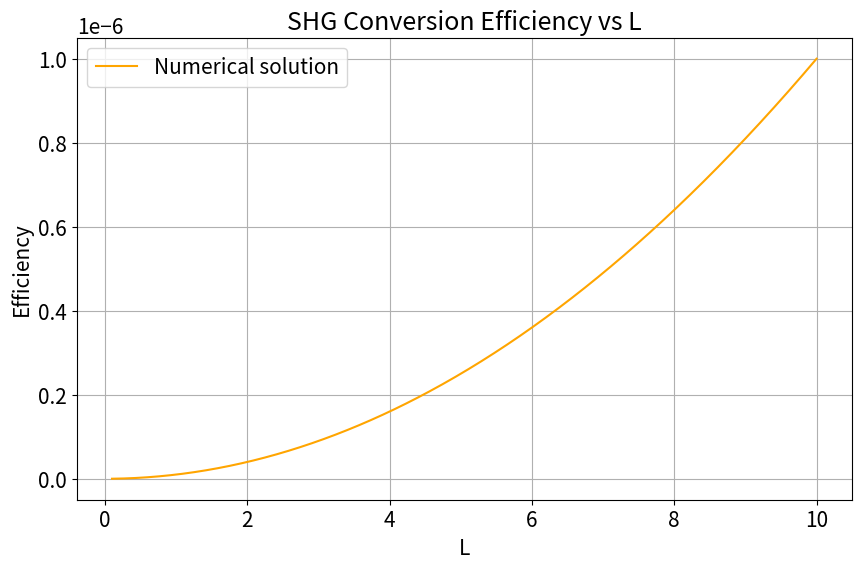

In [4]:
def L_vs_eff_numerical():
    kappa = 0.0001

    def twodelta(z: float) -> float:
        return 0.2

    # パラメータ設定
    A0 = 1.0 + 0j  # Initial condition for A(0)
    B0 = 0.0 + 0j  # Initial condition for B(0)
    L_values = np.linspace(0.1, 10, 600)

    # NMCEオブジェクトの作成
    nmce = shg.NCME(kappa, twodelta)

    # 効率計算
    efficiency_values = []
    for L in L_values:
        B_L = nmce.solve(L, A0, B0)
        efficiency = shg.efficiency(B_L, A0)  # 効率を計算
        efficiency_values.append(efficiency)  # 効率をリストに追加

    return L_values, efficiency_values


# 効率を計算
L_approx, eff_vals = L_vs_eff_numerical()

# グラフの描画
plt.figure(figsize=(10, 6))

# Lに対する効率のプロット
plt.plot(L_approx, eff_vals, label='Numerical solution', color='orange')

plt.title('SHG Conversion Efficiency vs L')
plt.xlabel('L')
plt.ylabel('Efficiency')
plt.grid()
plt.legend()
plt.show()

* $\Delta$を変化させたグラフ

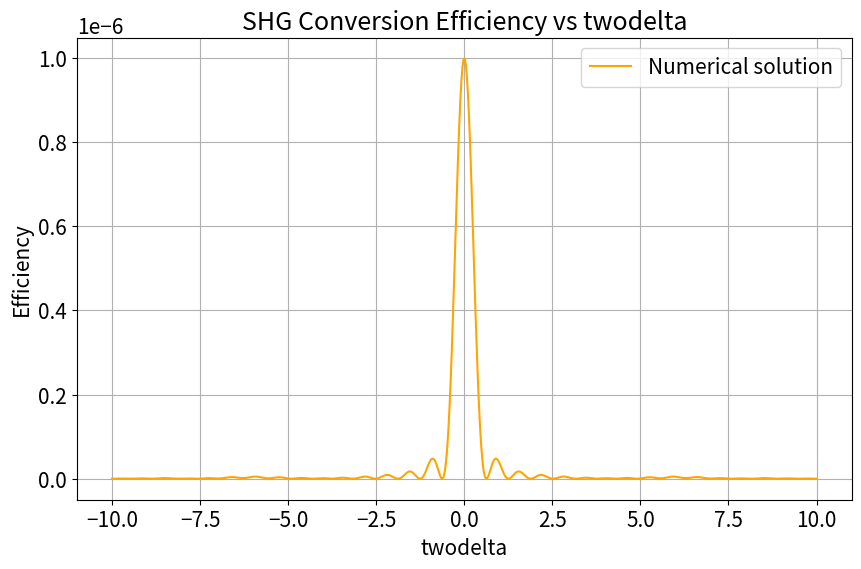

In [5]:
def twodelta_vs_eff_numerical():
    kappa = 0.0001

    # パラメータ設定
    A0 = 1.0 + 0j  # A(0) の初期条件
    B0 = 0.0 + 0j  # B(0) の初期条件
    L = 10  # L を固定
    twodelta_values = np.linspace(-10, 10, 600)

    # 効率計算
    efficiency_values = []
    for twodelta_value in twodelta_values:
        # twodelta(z) 関数を定義（z に依存しない定数を返す）
        def twodelta(z: float) -> float:
            return twodelta_value * z

        # NMCE オブジェクトの作成
        nmce = shg.NCME(kappa, twodelta)

        # 効率計算
        B_L = nmce.solve(L, A0, B0)
        efficiency = shg.efficiency(B_L, A0)  # 効率を計算
        efficiency_values.append(efficiency)  # 効率をリストに追加

    return twodelta_values, efficiency_values


# 効率を計算
twodelta_vals, eff_vals = twodelta_vs_eff_numerical()

# グラフの描画
plt.figure(figsize=(10, 6))

# twodelta に対する効率のプロット
plt.plot(twodelta_vals, eff_vals, label='Numerical solution', color='orange')

plt.title('SHG Conversion Efficiency vs twodelta')
plt.xlabel('twodelta')
plt.ylabel('Efficiency')
plt.grid()
plt.legend()
plt.show()

### 近似解の解析解

$\kappa$と$\Delta$が小さい時、変換効率が小さく、変換効率が小さい時以下のように近似できる

$$
\eta = \kappa^2 P_0 L^2 \left( \frac{\sin (\Delta L)}{\Delta L} \right)^2
$$

- $L$を変化させたグラフ

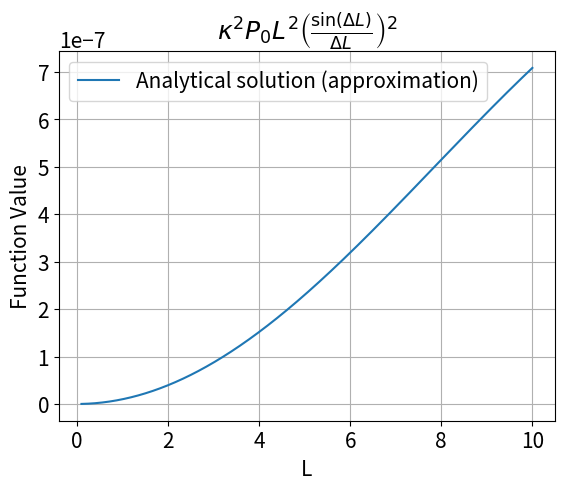

In [6]:
def L_vs_eff_analytical():
    kappa = 0.0001  # 小さい値を設定
    Delta = 0.1  # twodeltaの半分の値を設定
    A0 = 1.0
    P_0 = A0**2

    # Lの範囲を定義
    L = np.linspace(0.1, 10, 1000)

    # 近似関数
    def function(L, kappa, P_0, Delta):
        return kappa**2 * P_0 * L**2 * (np.sin(Delta * L) / (Delta * L))**2

    y_values = function(L, kappa, P_0, Delta)

    return L, y_values


L_approx, y_vals_approx = L_vs_eff_analytical()

plt.plot(L_approx, y_vals_approx, label="Analytical solution (approximation)")
plt.xlabel('L')
plt.ylabel('Function Value')
plt.title(
    r'$\kappa^2 P_0 L^2 \left( \frac{\sin (\Delta L)}{\Delta L} \right)^2$')
plt.grid(True)
plt.legend()
plt.show()

* $\Delta$を変化させたグラフ

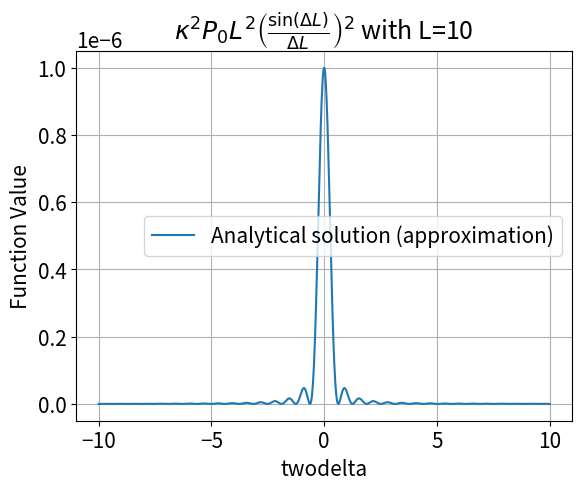

In [7]:
def twodelta_vs_eff_analytical():
    kappa = 0.0001  # 小さい値を設定
    L = 10  # Lを固定
    A0 = 1.0
    P_0 = A0**2

    # twodeltaの範囲を定義
    twodelta = np.linspace(-10, 10, 1000)

    # 近似関数
    def function(twodelta, kappa, P_0, L):
        Delta = twodelta / 2  # Deltaをtwodeltaの半分に設定
        return kappa**2 * P_0 * L**2 * (np.sin(Delta * L) / (Delta * L))**2

    y_values = function(twodelta, kappa, P_0, L)

    return twodelta, y_values


twodelta_vals_approx, y_vals_approx = twodelta_vs_eff_analytical()

plt.plot(twodelta_vals_approx, y_vals_approx,
         label='Analytical solution (approximation)')
plt.xlabel('twodelta')
plt.ylabel('Function Value')
plt.title(
    r'$\kappa^2 P_0 L^2 \left( \frac{\sin (\Delta L)}{\Delta L} \right)^2$ with L=10')
plt.grid(True)
plt.legend()
plt.show()

### 近似解と解析解の比較

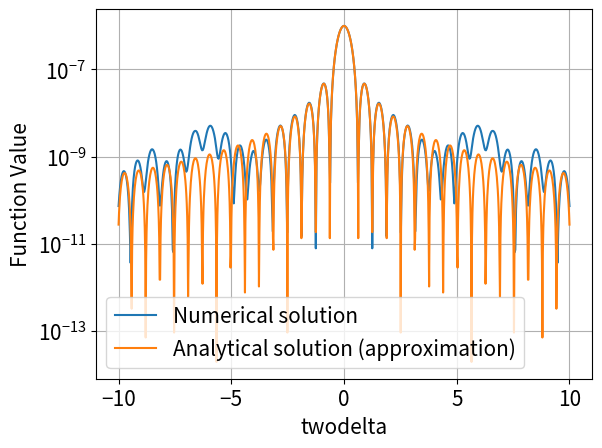

In [8]:
plt.plot(*twodelta_vs_eff_numerical(), label="Numerical solution")
plt.plot(*twodelta_vs_eff_analytical(),
         label="Analytical solution (approximation)")
plt.xlabel('twodelta')
plt.ylabel('Function Value')
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()

## 3. 次にやること

* 卒論の訂正
* デバイスの概略図を書く
* データセットを作成する
    * 入力は$\Delta$の配列
    * 出力はスペクトル分布
    
# 11/15の週報
  
## やることの整理

```mermaid
mindmap
  root((入射波に対する柔軟な
    波長依存性を持つ
    波長変換デバイスの設計))
    (順問題)
      (シミュレーション)
        (FDTD解析)
        (BPM法)
        (結合モード理論)
      (性能評価)
        (波長特性)
        (変換効率)
        (温度依存性)
    (逆問題による構造設計)
      (機械学習アプローチ)
        (学習データ生成)
          (構造パラメータの網羅的計算)
          (特性データベース構築)
        (モデル構築)
          (ニューラルネットワーク設計)
          (損失関数の定義)
          (学習・検証)
        (最適化)
          (目標特性からの構造導出)
          (多目的最適化)
      (設計制約)
        (製造可能性)
        (構造パラメータの範囲)
        (材料限界)
    (材料特性)
      (非線形光学効果)
        (位相整合条件)
        (変換効率)
      (分散特性)
        (群速度分散)
        (位相速度)
    (実験検証)
      (デバイス作製)
        (リソグラフィ)
        (エッチング)
      (特性評価)
        (予測値との比較)
        (モデル精度検証)
    (フィードバック)
      (実験結果の学習データへの反映)
      (モデルの更新・改良)
      (設計指針の確立)
```

## パラメータの整理

```mermaid
mindmap
  root((SHG変換効率
  のパラメータ))
    (結合係数 kappa)
      (意味)
        (非線形光学効果の強さ)
      (計算)
        (-波長に依存)
    (位相不整合 2delta)
      (意味)
        (基本波と高調波の位相差)
      (計算)
        (-波長に依存)
      (パラメータΛ)
        (分極反転周期)
        (-これを変化させてシミュレーションしたい)
    (伝搬長 L)
      (意味)
        (デバイス長)
      (計算)
        (固定でよさげ)
    (初期条件)
      (A0 入射基本波)
        (振幅 1.0)
        (パワーに換算可能)
      (B0 初期SH波)
        (通常は0)
        (初期位相0)
        (パワーに換算可能)
```

- 毎回の計算でkappaが変化
  - 波長依存性を持つため
- 個々のループ内での計算中、Λが変化する予定
  - 最適なΛの配列を探索するのが目的
- 野呂さんの計算データと比較したい
  - Λを固定した状態でのkappa依存性
  - 野呂さんのを表示してみたところkappaは1.30756E-05から1.29932E-05の範囲
  - 野呂さんのを表示してみたところdeltaは7.83E-03から-1.40E-03の範囲
  - 近似式による計算からsinc関数っぽい図が得られている
- NMCE解いて計算した結果と野呂さんの結果を比較する

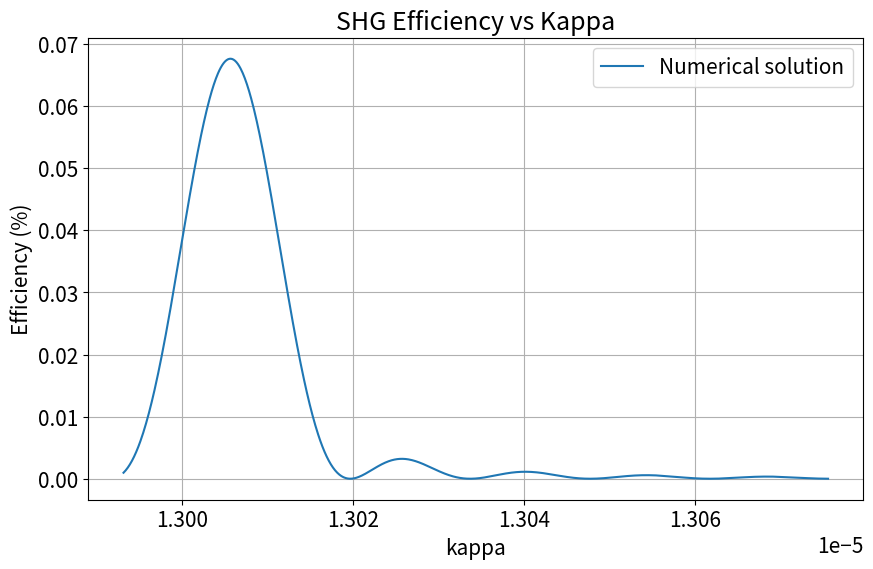

In [9]:
def preodical_eff_numerical():
    # パラメータ設定
    A0 = 1.0 + 0j  # Initial condition for A(0)
    B0 = 0.0 + 0j  # Initial condition for B(0)
    P0 = abs(A0)**2
    L = 2000
    n = 1000

    # 範囲設定
    twodelta_vals = np.linspace(7.83E-03, -1.40E-03, n)
    kappa_points = np.linspace(1.30756E-05, 1.29932E-05, n)
    effs = []

    for i in range(n):
        def twodelta(z: float) -> float:
            return twodelta_vals[i] * 2 * z

        nmce = shg.NCME(kappa_points[i], twodelta)
        B_L = nmce.solve(L, A0, B0)
        eff = shg.efficiency(B_L, A0) / P0 * 100  # P0で割って100をかける
        effs.append(eff)

    return kappa_points, effs


# プロット
plt.figure(figsize=(10, 6))
plt.plot(*preodical_eff_numerical(), label="Numerical solution")
plt.xlabel('kappa')
plt.ylabel('Efficiency (%)')
plt.title('SHG Efficiency vs Kappa')
plt.grid(True)
plt.legend()
plt.show()

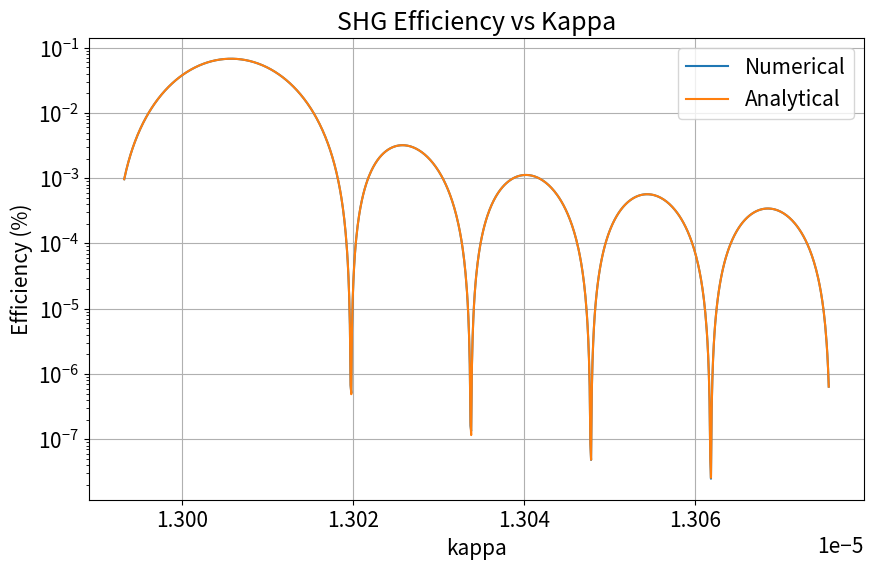

In [10]:
def preodical_eff_analytical():
    # パラメータ設定
    A0 = 1.0
    P_0 = A0**2
    L = 2000  # Fixed L value

    # kappaの範囲設定
    n = 1000
    kappa_points = np.linspace(1.30756E-05, 1.29932E-05, n)
    delta_vals = np.linspace(7.83E-03, -1.40E-03, n)  # twodeltaの半分

    # 近似関数を使用して効率を計算
    def function(kappa, P_0, L, Delta):
        return kappa**2 * P_0 * L**2 * (np.sin(Delta * L) / (Delta * L))**2

    # 各点での効率を計算
    efficiency_values = [function(
        kappa, P_0, L, delta) * 100 for kappa, delta in zip(kappa_points, delta_vals)]

    return kappa_points, efficiency_values


plt.figure(figsize=(10, 6))
kappa_num, eff_num = preodical_eff_numerical()
kappa_ana, eff_ana = preodical_eff_analytical()
plt.plot(kappa_num, eff_num, label="Numerical")
plt.plot(kappa_ana, eff_ana, label="Analytical")
plt.yscale("log")
plt.xlabel('kappa')
plt.ylabel('Efficiency (%)')
plt.title('SHG Efficiency vs Kappa')
plt.grid(True)
plt.legend()
plt.show()

野呂さんのデータを用いて書いた図

- 以下の図からkappaとlambdaは比例していることがわかる、周期以外の条件が変わらない時、kappa依存性がわかれば波長依存性もわかる

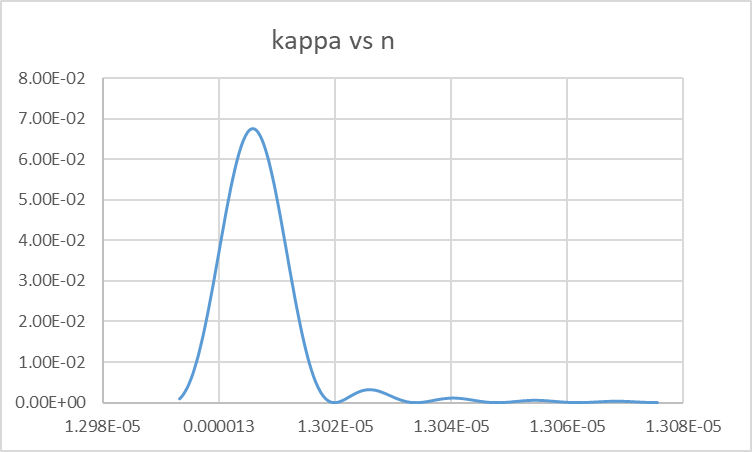
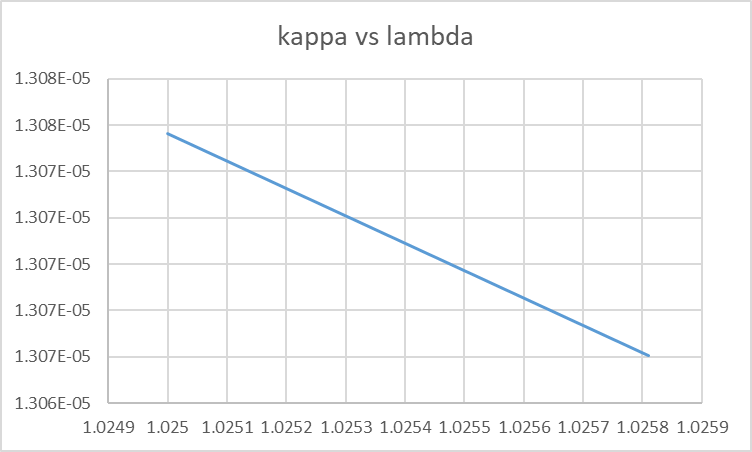

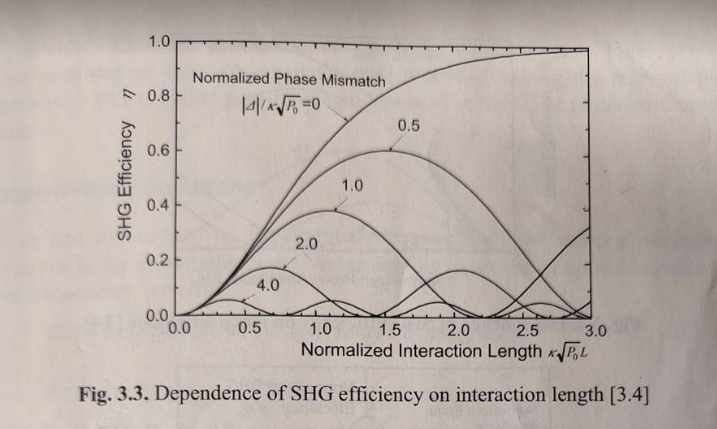

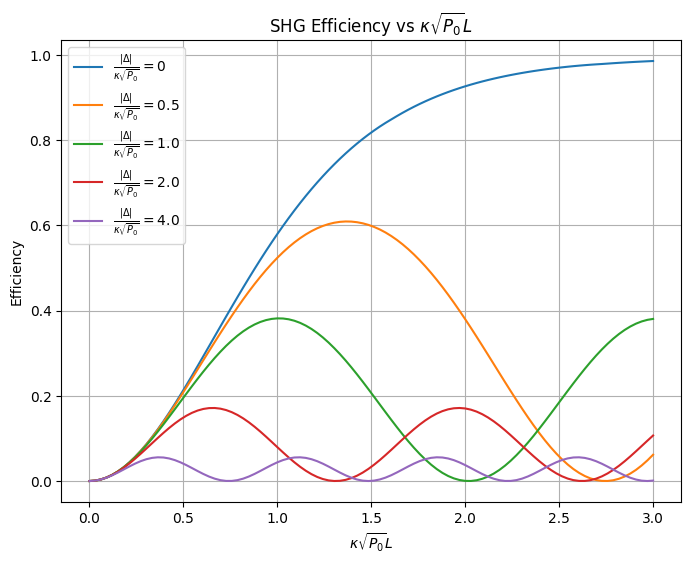

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from syuron import shg

P0 = 1.0  # P0 = |A0|^2
A0 = np.sqrt(P0)  # A0 = sqrt(P0)
kappa = 0.0001
delta_ratios = [0, 0.5, 1.0, 2.0, 4.0]  # |Δ| / (κ √P0) の値

# 横軸の範囲
kappa_sqrtP0_L_values = np.linspace(0, 3, 100)  # 横軸: κ √P0 L (0.0 ~ 3.0)

# グラフの描画
plt.figure(figsize=(8, 6))
for delta_ratio in delta_ratios:
    Delta = delta_ratio * kappa * np.sqrt(P0)  # |Δ| = (Δ/κ√P0) * κ√P0

    # 2Δ(z) の関数
    def twodeltaone(z):
        return 2 * Delta * z  # 2Δ(z) = 2Δ * z

    efficiencies = []
    for kappa_sqrtP0_L in kappa_sqrtP0_L_values:
        L = kappa_sqrtP0_L / (kappa * np.sqrt(P0))  # L = (κ √P0 L) / (κ √P0)
        nmce = shg.NCME(kappa, twodeltaone)
        B_L = nmce.solve(L, A0, B0=0)
        eff = shg.efficiency(B_L, A0)
        efficiencies.append(eff)
    plt.plot(kappa_sqrtP0_L_values, efficiencies,
             label=rf"$\frac{{|\Delta|}}{{\kappa \sqrt{{P_0}}}} = {delta_ratio}$")

# グラフの装飾
plt.xlabel(r"$\kappa \sqrt{P_0} L$")
plt.ylabel("Efficiency")
plt.title(r"SHG Efficiency vs $\kappa \sqrt{P_0} L$")
plt.grid(True)
plt.legend()
plt.show()

## チャープした分極反転構造の時

$$
2\beta^{\omega} + K_0 = \beta^{2\omega} \\
\text{or} \\
\Lambda_0 = (\lambda/2)/(N^{2\omega} - N^{\omega})
$$

$$
\Lambda(z) = \Lambda_0 / (1 + rz) \\
K(z) = 2\pi / \Lambda(z) \\
\Phi(z) = K_0[z+(r/2)z^2] \\
2\Delta_q(z) = \beta^{2 \omega}z - [2\beta^{\omega}z + q\Phi(z)]
$$

$\beta$は$N$と$\lambda$から求まる

$r$に0を代入すると周期分極反転構造の場合の計算が可能


## 位相整合条件と周期 $\Lambda_0$ の導出

### 1. 位相整合条件
基本波 ($\omega$) と第二高調波 ($2\omega$) の伝搬定数の関係は、位相整合条件として次式で与えられます。

$$
\beta^{2\omega} = 2\beta^{\omega} + K_0
$$

ここで、$K_0$ は波数で、周期分極反転構造の周期 $\Lambda_0$ と次の関係があります。

$$
K_0 = \frac{2\pi}{\Lambda_0}
$$

---

### 2. 伝搬定数の定義
伝搬定数 $\beta^{\omega}$ と $\beta^{2\omega}$ は、波長 $\lambda$ と実行屈折率 $N$ を用いて次のように表されます。

- 基本波 ($\omega$) の伝搬定数:
  $$
  \beta^{\omega} = \frac{2\pi}{\lambda} N^{\omega}
  $$

- 第二高調波 ($2\omega$) の伝搬定数:
  $$
  \beta^{2\omega} = \frac{2\pi}{\lambda/2} N^{2\omega} = \frac{4\pi}{\lambda} N^{2\omega}
  $$

ここで、第二高調波の波長 $\lambda^{2\omega}$ は基本波の波長 $\lambda$ の半分 ($\lambda^{2\omega} = \lambda/2$) です。

---

### 3. 位相整合条件に代入
位相整合条件 $\beta^{2\omega} = 2\beta^{\omega} + K_0$ に、$\beta^{\omega}$ と $\beta^{2\omega}$ の式を代入します。

$$
\frac{4\pi}{\lambda} N^{2\omega} = 2 \left( \frac{2\pi}{\lambda} N^{\omega} \right) + K_0
$$

これを整理すると、

$$
K_0 = \frac{4\pi}{\lambda} (N^{2\omega} - N^{\omega})
$$

---

### 4. 周期 $\Lambda_0$ の導出
波数 $K_0$ と周期 $\Lambda_0$ の関係 $K_0 = \frac{2\pi}{\Lambda_0}$ を用いて、$\Lambda_0$ を求めます。

$$
\frac{2\pi}{\Lambda_0} = \frac{4\pi}{\lambda} (N^{2\omega} - N^{\omega})
$$

両辺を整理すると、

$$
\Lambda_0 = \frac{\lambda/2}{N^{2\omega} - N^{\omega}}
$$

---

### 5. まとめ
以上から、周期 $\Lambda_0$ は次のように表されます。

$$
\Lambda_0 = \frac{\lambda/2}{N^{2\omega} - N^{\omega}}
$$

## 野呂さんの計算結果との比較

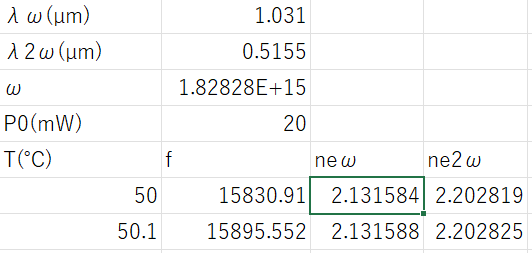



In [12]:
from syuron import shg
import numpy as np
from IPython.display import display, Math  # LaTeX表示用

lambda_val = 1.031
T = 70

# 屈折率の計算
N_omega = shg.calculate_refractive_index(lambda_val, T)
N_2omega = shg.calculate_refractive_index(lambda_val / 2, T)

# LaTeXで表示
display(Math(fr"N_\omega = {round(N_omega, 6)}"))
display(Math(fr"N_{{2\omega}} = {round(N_2omega, 6)}"))

# 位相整合長の計算
Lambda_0 = (lambda_val / 2) / (N_2omega - N_omega)
display(Math(
    fr"\Lambda_0 = \frac{{\lambda / 2}}{{N_{{2\omega}} - N_\omega}} = {Lambda_0}"))

# 波数の計算
K0 = 2 * np.pi / Lambda_0
display(Math(fr"K_0 = \frac{{2\pi}}{{\Lambda_0}} = {K0}"))

# 位相定数の計算
beta_omega = (2 * np.pi / lambda_val) * N_omega
beta_2omega = (4 * np.pi / lambda_val) * N_2omega
display(
    Math(fr"\beta_\omega = \frac{{2\pi}}{{\lambda}} N_\omega = {beta_omega}"))
display(Math(
    fr"\beta_{{2\omega}} = \frac{{4\pi}}{{\lambda}} N_{{2\omega}} = {beta_2omega}"))

# 位相ミスマッチの計算
twodeltaone = beta_2omega - (2 * beta_omega + K0)
display(
    Math(fr"2\Delta_1 = \beta_{{2\omega}} - (2\beta_\omega + K_0) = {twodeltaone}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Initial Lambda: 7.201665744029974
Exit Lambda: 6.001388120024979


Calculating SHG Efficiency:   1%|          | 7/1000 [00:00<00:16, 61.94it/s]

Calculating SHG Efficiency: 100%|██████████| 1000/1000 [00:09<00:00, 100.88it/s]



最大効率: 1.755954049375736e-05
最大効率に対応する波長: 1.023027027027027 µm


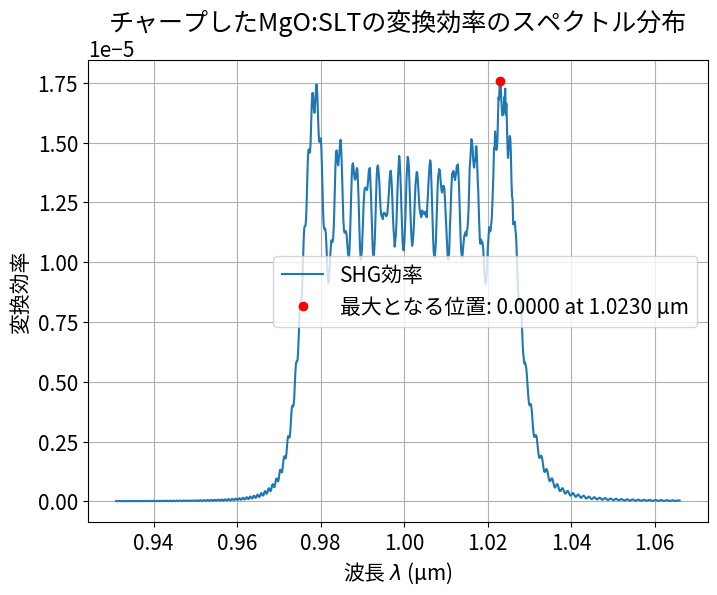

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from syuron import shg
from tqdm import tqdm


# 定数
P0 = 1.0  # P0 = |A0|^2
kappa = 1.31E-05  # 野呂さんの値
L = 2000  # 固定長さ
r = 0.0001  # チャープパラメータ（周期分極反転構造の場合は0）
T = 70

# 位相整合条件
pm_lambda = 1.031

# 波長範囲
lambda_min = pm_lambda - 0.1
lambda_max = pm_lambda + 0.035
lambda_values = np.linspace(lambda_min, lambda_max, 1000)  # 横軸: 波長 λ

grating = shg.ChirpedGrating(P0, kappa, L, r, T, pm_lambda)

Lambda_i = grating.Lambda_z(0)
print(f"Initial Lambda: {Lambda_i}")
Lambda_e = grating.Lambda_z(2000)
print(f"Exit Lambda: {Lambda_e}")

# 波長ごとに変換効率を計算
efficiencies = []
for lambda_val in tqdm(lambda_values, desc="Calculating SHG Efficiency"):  # tqdmで進捗表示
    eff = grating.calculate_efficiency(lambda_val)  # 変換効率を計算
    efficiencies.append(eff)

# グラフの描画
plt.figure(figsize=(8, 6))
plt.plot(lambda_values, efficiencies, label="SHG効率")

# グラフの装飾
plt.xlabel(r"波長 $\lambda$ (µm)")
plt.ylabel("変換効率")
plt.title("チャープしたMgO:SLTの変換効率のスペクトル分布")
plt.grid(True)
plt.legend()

# 最大効率とそのインデックスを取得
max_efficiency = max(efficiencies)
max_index = efficiencies.index(max_efficiency)
max_lambda = lambda_values[max_index]

# 最大値とその波長を表示
print(f"\n最大効率: {max_efficiency}")
print(f"最大効率に対応する波長: {max_lambda} µm")

# グラフに最大値をプロット
plt.plot(max_lambda, max_efficiency, 'ro',
         label=f"最大となる位置: {max_efficiency:.4f} at {max_lambda:.4f} µm")
plt.legend()
plt.show()

Calculating SHG Efficiency (T=20): 100%|██████████| 1000/1000 [00:01<00:00, 532.89it/s]



T = 20
最大効率: 0.000686125021264872
最大効率に対応する波長: 1.0270520520520519 µm


Calculating SHG Efficiency (T=50): 100%|██████████| 1000/1000 [00:01<00:00, 655.77it/s]



T = 50
最大効率: 0.0006861259306314203
最大効率に対応する波長: 1.0293043043043042 µm


Calculating SHG Efficiency (T=70): 100%|██████████| 1000/1000 [00:01<00:00, 675.64it/s]



T = 70
最大効率: 0.0006861091553070544
最大効率に対応する波長: 1.0309259259259258 µm


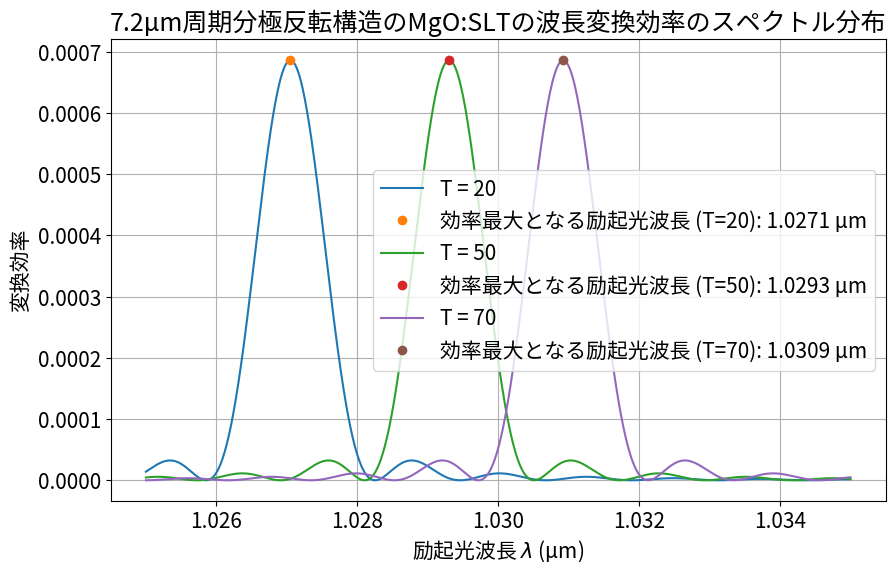

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from syuron import shg
from tqdm import tqdm

# 定数
P0 = 1.0  # P0 = |A0|^2
kappa = 1.31E-05  # 野呂さんの値
L = 2000  # 固定長さ
r = 0  # チャープパラメータ（周期分極反転構造の場合は0）
T_values = [20, 50, 70]  # T の値をリストで定義

# 位相整合条件
Lambda_0 = 7.2

# 波長囲
lambda_min = 1.025
lambda_max = 1.035
lambda_values = np.linspace(lambda_min, lambda_max, 1000)  # 横軸: 波長 λ

# グラフの描画
plt.figure(figsize=(10, 6))

for T in T_values:
    grating = shg.ChirpedGrating(P0, kappa, L, r, T, Lambda_0=Lambda_0)

    # 波長ごとに変換効率を計算
    efficiencies = []
    for lambda_val in tqdm(lambda_values, desc=f"Calculating SHG Efficiency (T={T})"):
        eff = grating.calculate_efficiency(lambda_val)  # 変換効率を計算
        efficiencies.append(eff)

    # グラフにプロット
    plt.plot(lambda_values, efficiencies, label=f"T = {T}")

    # 最大効率とそのインデックスを取得
    max_efficiency = max(efficiencies)
    max_index = efficiencies.index(max_efficiency)
    max_lambda = lambda_values[max_index]

    # 最大値とその波長を表示
    print(f"\nT = {T}")
    print(f"最大効率: {max_efficiency}")
    print(f"最大効率に対応する波長: {max_lambda} µm")

    # グラフに最大値をプロット
    plt.plot(max_lambda, max_efficiency, 'o',
             label=f"効率最大となる励起光波長 (T={T}): {max_lambda:.4f} µm")

# グラフの装飾
plt.xlabel(r"励起光波長 $\lambda$ (µm)")
plt.ylabel("変換効率")
plt.title(
    r"7.2µm周期分極反転構造のMgO:SLTの波長変換効率のスペクトル分布")
plt.grid(True)
plt.legend()
plt.show()

## 考察

デバイスがチャープして分極反転周期が短くなっている

分極反転周期が短くなると最も波長変換する励起光波長が小さくなっていく

様々な場所で様々な波長での波長変換が起こる

デバイスの最初の端で一番変換される波長、デバイスの最後の端で一番変換される波長、等が存在する

だから先端で変換される波長を最大値、末端で変換される波長を最小値として効率の良い波長が分布している現在の状況は理にかなっていると思われる

start: 7.199927993519417, end: 6.000050005423479


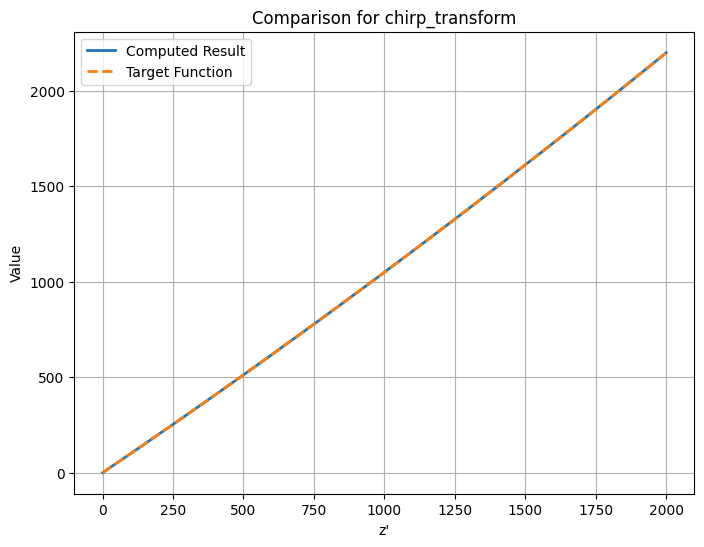

start: 4.8, end: 4.8


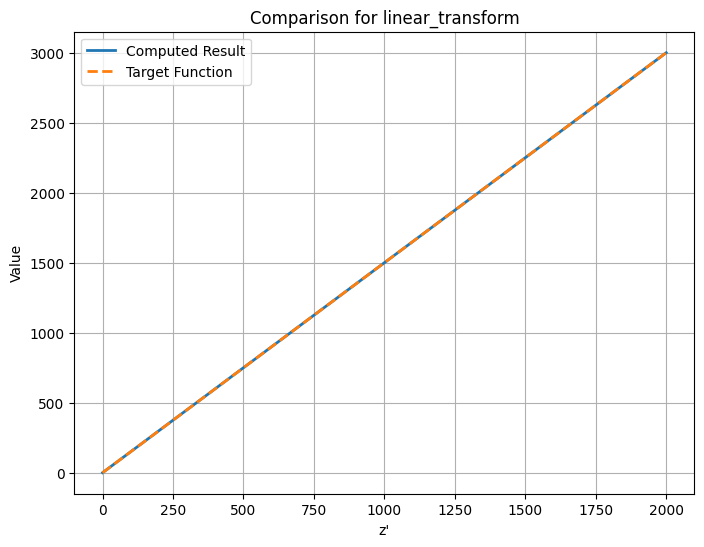

start: 4.800001066880055, end: 5.977596898449676


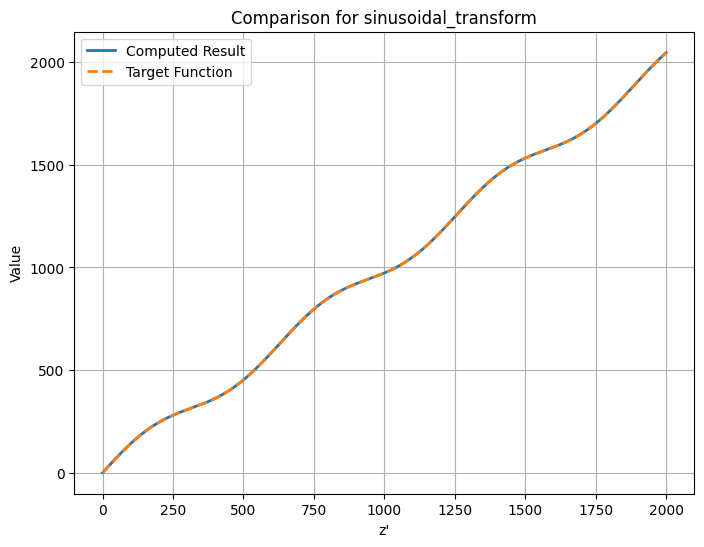

start: 7.198560000004801, end: 0.3248479935554433


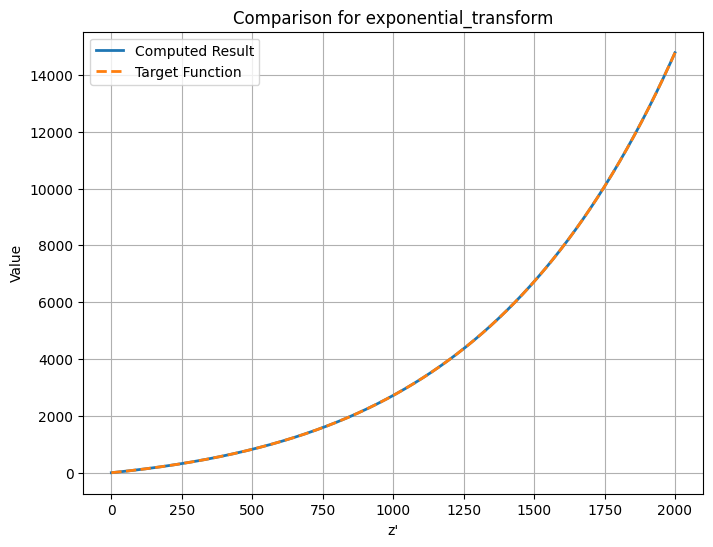

start: 7.2007200480027755, end: 21.599279919907378


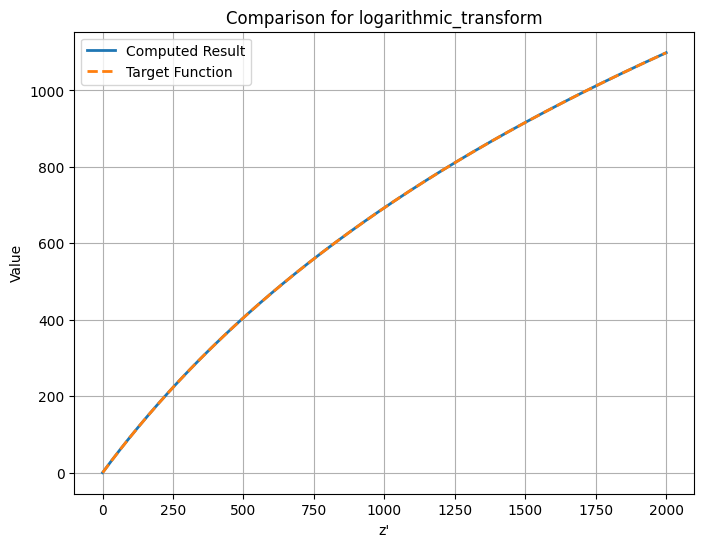

In [1]:
import numpy as np
from syuron import shg


# オブザーバーの初期化
resolution = 10000
domain_size = 2000
period = 7.2

observer = shg.PeriodicObserver(resolution, domain_size, period)


# チャープした周期構造
def chirp_transform(z_prime):
    r = 0.0001  # チャープパラメータ
    return z_prime + (r / 2) * z_prime**2


# 線形変換
def linear_transform(z_prime):
    return 1.5 * z_prime


# 正弦波による変換
def sinusoidal_transform(z_prime):
    amplitude = 50
    frequency = 0.01
    return z_prime + amplitude * np.sin(frequency * z_prime)


# 指数関数による変換
def exponential_transform(z_prime):
    return z_prime * np.exp(0.001 * z_prime)


# 対数関数による変換
def logarithmic_transform(z_prime):
    return 1000 * np.log(1 + 0.001 * z_prime)


# テスト関数をリストにまとめる
transform_functions = [
    chirp_transform,
    linear_transform,
    sinusoidal_transform,
    exponential_transform,
    logarithmic_transform
]

# 各変換関数に対してテストを実行
for transform_func in transform_functions:
    # 1. 座標変換を適用して非周期的な層の幅を計算
    distribution = observer.observe_from_transformed(transform_func)
    print(f"start: {distribution[0]}, end: {distribution[-1]}")

    # 2. 非周期的な層が周期的に見える座標系からの座標変換を計算
    descrete_transform = observer.infer_transform(distribution)

    # 3. 実際に適用した座標変換と逆算された座標変換を比較
    observer.compare(descrete_transform, transform_func,
                     title=f"Comparison for {transform_func.__name__}")

Calculating SHG Efficiency: 100%|██████████| 1000/1000 [01:54<00:00,  8.77it/s]



最大効率: 7.124347450880101e-05
最大効率に対応する波長: 1.0273513513513512 µm


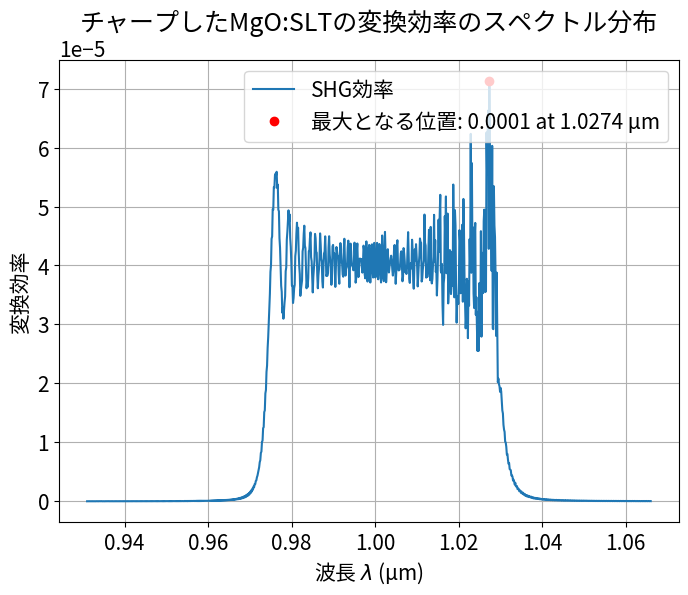

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from syuron import shg
from tqdm import tqdm

# 定数
P0 = 1.0  # P0 = |A0|^2
kappa = 1.31E-05  # 野呂さんの値
L = 2000  # 固定長さ
r = 0.0001  # チャープパラメータ（周期分極反転構造の場合は0）
T = 70  # 温度 (°C)

# 位相整合条件
pm_lambda = 1.031

# Λ(z) = Λ_0 / (1 + 0.0001z) を離散化して widths を作成
Lambda_0 = 7.2  # 基準波長
resolution = 1000  # 解像度
z_values = np.linspace(0, L, resolution)
widths = Lambda_0 / (1 + r * z_values)

# Grating クラスのインスタンスを作成
grating = shg.Grating(widths, P0, kappa, T, resolution)

# 波長ごとに変換効率を計算
efficiencies = []
for lambda_val in tqdm(lambda_values, desc="Calculating SHG Efficiency"):  # tqdmで進捗表示
    eff = grating.calculate_efficiency(lambda_val)  # 変換効率を計算
    efficiencies.append(eff)

# グラフの描画
plt.figure(figsize=(8, 6))
plt.plot(lambda_values, efficiencies, label="SHG効率")

# グラフの装飾
plt.xlabel(r"波長 $\lambda$ (µm)")
plt.ylabel("変換効率")
plt.title("チャープしたMgO:SLTの変換効率のスペクトル分布")
plt.grid(True)
plt.legend()

# 最大効率とそのインデックスを取得
max_efficiency = max(efficiencies)
max_index = efficiencies.index(max_efficiency)
max_lambda = lambda_values[max_index]

# 最大値とその波長を表示
print(f"\n最大効率: {max_efficiency}")
print(f"最大効率に対応する波長: {max_lambda} µm")

# グラフに最大値をプロット
plt.plot(max_lambda, max_efficiency, 'ro',
         label=f"最大となる位置: {max_efficiency:.4f} at {max_lambda:.4f} µm")
plt.legend()
plt.show()